In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import packages

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import ensemble
from xgboost import XGBClassifier
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier

In [ ]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

# Load dataset

In [ ]:
train = pd.read_csv('drive/MyDrive/Colab Notebooks/fashion-mnist_train.csv')
test = pd.read_csv('drive/MyDrive/Colab Notebooks/fashion-mnist_test.csv')

In [ ]:
df_train = train.copy()
df_test = test.copy()

# Examine NaN values

In [ ]:
df_train.isnull().any().sum()

0

In [ ]:
df_test.isnull().any().sum()

0

# Separating data and label

In [ ]:
X_train= df_train.drop(['label'],axis = 1)
y_train = df_train['label']
X_test = df_test.drop(['label'], axis=1)
y_test = df_test['label']  # y_test should be labels

# Normalization
The Pixel Values are often stored as Integer Numbers in the range 0 to 255, the range that a single 8-bit byte can offer. They need to be scaled down to [0,1] in order for Optimization Algorithms to work much faster. Here, we acheive Zero Mean and Unit Variance.

In [ ]:

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')  # X_test should be features
X_train /= 255.0
X_test /= 255.0  # X_test should be features

# Dimensionality Reduction using PCA
The advantage of PCA (and dimensionality reduction in general) is that it compresses the data down to something that is more effectively modeled. This means that it will, for example, compress away highly correlated and colinear variables, a useful thing to do when trying to run models that would otherwise be sensitive to these sort of data problems.

In [ ]:
pca = PCA(n_components=100, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)  # Apply PCA transform to test data

# Evaluate the model

In [ ]:
seed = 42

# 5개의 서로 다른 SVM 모델 정의
svc1 = SVC(C=4.419450186421157, gamma='scale', kernel='rbf', random_state=seed, probability=True)
svc2 = SVC(C=13, gamma="auto", kernel='rbf', random_state=seed+1, probability=True)
svc3 = SVC(C=5.0, gamma='scale', kernel='rbf', random_state=seed+2, probability=True)
svc4 = SVC(C=10, gamma='scale', kernel='rbf', random_state=seed+3, probability=True)
svc5 = SVC(C=8, gamma='scale', kernel='rbf', random_state=seed+4, probability=True)

# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# To store the ensemble models for each fold
ensemble_models = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, val in kfold.split(X_train_pca, y_train):

  # 앙상블 모델 정의
  eclf = VotingClassifier(estimators=[('svc1', svc1), ('svc2', svc2), ('svc3', svc3), ('svc4', svc4), ('svc5', svc5)], voting='hard')

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  eclf.fit(X_train_pca[train], y_train.iloc[train])

  # Save the model
  ensemble_models.append(eclf)

  fold_no = fold_no + 1

# Select the best model
best_model = ensemble_models[np.argmax([accuracy_score(y_train, model.predict(X_train_pca)) for model in ensemble_models])]

------------------------------------------------------------------------
Training for fold 1 ...
------------------------------------------------------------------------
Training for fold 2 ...
------------------------------------------------------------------------
Training for fold 3 ...
------------------------------------------------------------------------
Training for fold 4 ...
------------------------------------------------------------------------
Training for fold 5 ...


# Predicting the models

***SVM Report and Analysis***

In [14]:
# Make predictions on the test data
y_test_pred = best_model.predict(X_test_pca)  # Predict with PCA transformed test data

# Calculate the accuracy score
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)

# Print the test accuracy score
print("Test Accuracy score: {}".format(test_accuracy))

# Print the classification report
print(metrics.classification_report(y_test, y_test_pred))

Test Accuracy score: 0.9036
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1000
           1       0.99      0.98      0.99      1000
           2       0.84      0.83      0.84      1000
           3       0.91      0.92      0.91      1000
           4       0.85      0.86      0.85      1000
           5       0.98      0.95      0.97      1000
           6       0.76      0.72      0.74      1000
           7       0.93      0.96      0.95      1000
           8       0.98      0.98      0.98      1000
           9       0.96      0.97      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



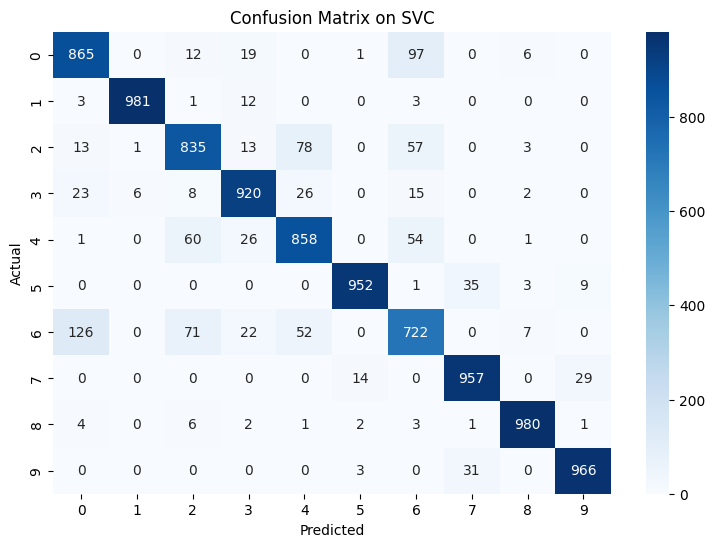

In [15]:
con_matrix = pd.crosstab(pd.Series(y_test.values.flatten(), name='Actual'), pd.Series(y_test_pred, name='Predicted'))
plt.figure(figsize = (9,6))
plt.title("Confusion Matrix on SVC")
sns.heatmap(con_matrix, cmap="Blues", annot=True, fmt='g')
plt.show()